In [1]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
import math
import random
import numpy as np
from scipy.optimize import minimize
from qiskit_ibm_provider import IBMProvider

try:
    from qiskit_ionq import IonQProvider, ErrorMitigation
except (ImportError):
    %pip install qiskit-ionq
    from qiskit_ionq import IonQProvider, ErrorMitigation

from qiskit_aer.noise import NoiseModel, depolarizing_error, pauli_error 
from qiskit_aer import AerSimulator

try:
    from qiskit_ionq import IonQProvider
except ImportError:
    %pip install --quiet qiskit-ionq
    from qiskit_ionq import IonQProvider 

from IonQAPIservice import IonQAPIservice

f = open("C:\\Users\\fouad\\Documents\\tokens.txt", "r")
next = f.readline()
TOKEN = next[:len(next)-1]
next = f.readline()
TOKEN_IONQ = next[:len(next)-1]

service = IonQAPIservice(TOKEN_IONQ)

 Name              Qubits   Status   Access?  Degraded?  avg. Queue Time  (last updated)
 qpu.harmony:       11    available    Yes      No               2:30:19  (2023-08-23 10:56:17)
 qpu.aria-1:        25    available    Yes      No       2 days, 2:08:52  (2023-08-23 10:56:17)
 simulator:         29    available    Yes      No               0:00:16  (2023-08-23 10:56:17)


In [2]:
# backend uses the IonQ native simulator
provider = IonQProvider(TOKEN_IONQ)
backend = provider.get_backend('ionq_simulator')
backend_type = "(IonQ Simulator, no noise)"

DEBIAS = False

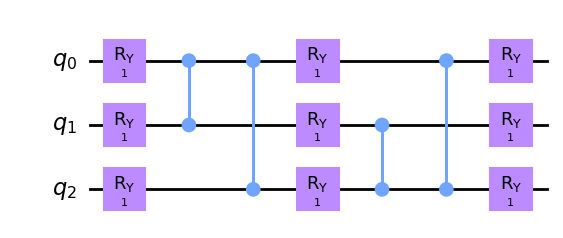

In [3]:
def apply_fixed_ansatz(qubits, parameters):

    for iz in range (0, len(qubits)):
        circ.ry(parameters[0][iz], qubits[iz])

    circ.cz(qubits[0], qubits[1])
    circ.cz(qubits[2], qubits[0])

    for iz in range (0, len(qubits)):
        circ.ry(parameters[1][iz], qubits[iz])

    circ.cz(qubits[1], qubits[2])
    circ.cz(qubits[2], qubits[0])

    for iz in range (0, len(qubits)):
        circ.ry(parameters[2][iz], qubits[iz])

circ = QuantumCircuit(3)
apply_fixed_ansatz([0, 1, 2], [[1, 1, 1], [1, 1, 1], [1, 1, 1]])
circ.draw('mpl')

In [4]:
# Creates the Hadamard test

def had_test(gate_type, qubits, auxiliary_index, parameters):

    circ.h(auxiliary_index)

    apply_fixed_ansatz(qubits, parameters)

    for ie in range (0, len(gate_type[0])):
        if (gate_type[0][ie] == 1):
            circ.cz(auxiliary_index, qubits[ie])
        if (gate_type[0][ie] == 2):
            circ.cx(auxiliary_index, qubits[ie])

    for ie in range (0, len(gate_type[1])):
        if (gate_type[1][ie] == 1):
            circ.cz(auxiliary_index, qubits[ie])
        if (gate_type[1][ie] == 2):
            circ.cx(auxiliary_index, qubits[ie])
    
    circ.h(auxiliary_index)
    
circ = QuantumCircuit(4)
had_test([[0, 0, 0], [0, 0, 1]], [1, 2, 3], 0, [[1, 1, 1], [1, 1, 1], [1, 1, 1]])
circ.draw()

┌───┐                                   ┌───┐
q_0: ──┤ H ├─────────────────────────────────■─┤ H ├
     ┌─┴───┴─┐      ┌───────┐      ┌───────┐ │ └───┘
q_1: ┤ Ry(1) ├─■──■─┤ Ry(1) ├────■─┤ Ry(1) ├─┼──────
     ├───────┤ │  │ ├───────┤    │ ├───────┤ │      
q_2: ┤ Ry(1) ├─■──┼─┤ Ry(1) ├─■──┼─┤ Ry(1) ├─┼──────
     ├───────┤    │ ├───────┤ │  │ ├───────┤ │      
q_3: ┤ Ry(1) ├────■─┤ Ry(1) ├─■──■─┤ Ry(1) ├─■──────
     └───────┘      └───────┘      └───────┘

In [5]:
# Creates controlled anstaz for calculating |<b|psi>|^2 with a Hadamard test

def control_fixed_ansatz(qubits, parameters, auxiliary, reg):

    for i in range (0, len(qubits)):
        circ.cry(parameters[0][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

    circ.ccx(auxiliary, qubits[1], qubits[2]+1)
    circ.cz(qubits[0], qubits[2]+1)
    circ.ccx(auxiliary, qubits[1], qubits[2]+1)

    circ.ccx(auxiliary, qubits[0], qubits[2]+1)
    circ.cz(qubits[2], qubits[2]+1)
    circ.ccx(auxiliary, qubits[0], qubits[2]+1)

    for i in range (0, len(qubits)):
        circ.cry(parameters[1][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

    circ.ccx(auxiliary, qubits[2], qubits[2]+1)
    circ.cz(qubits[1], qubits[2]+1)
    circ.ccx(auxiliary, qubits[2], qubits[2]+1)

    circ.ccx(auxiliary, qubits[0], qubits[2]+1)
    circ.cz(qubits[2], qubits[2]+1)
    circ.ccx(auxiliary, qubits[0], qubits[2]+1)

    for i in range (0, len(qubits)):
        circ.cry(parameters[2][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

q_reg = QuantumRegister(5)
c_reg = ClassicalRegister(5)
circ = QuantumCircuit(q_reg, c_reg)
control_fixed_ansatz([1, 2, 3], [[1, 1, 1], [1, 1, 1], [1, 1, 1]], 0, q_reg)
display(circ.draw())

»
q0_0: ────■────────■────────■──────■───────■────■───────■──────■────────■────»
      ┌───┴───┐    │        │      │       │    │       │  ┌───┴───┐    │    »
q0_1: ┤ Ry(1) ├────┼────────┼──────┼───■───┼────■───────■──┤ Ry(1) ├────┼────»
      └───────┘┌───┴───┐    │      │   │   │    │       │  └───────┘┌───┴───┐»
q0_2: ─────────┤ Ry(1) ├────┼──────■───┼───■────┼───────┼───────────┤ Ry(1) ├»
               └───────┘┌───┴───┐  │   │   │    │       │           └───────┘»
q0_3: ──────────────────┤ Ry(1) ├──┼───┼───┼────┼───■───┼────────────────────»
                        └───────┘┌─┴─┐ │ ┌─┴─┐┌─┴─┐ │ ┌─┴─┐                  »
q0_4: ───────────────────────────┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├──────────────────»
                                 └───┘   └───┘└───┘   └───┘                  »
c0: 5/═══════════════════════════════════════════════════════════════════════»
                                                                             »
«                                                                    
«q0_0: ────■──────■───────■────■───────■──────■────────■────────■────
«          │      │       │    │       │  ┌───┴───┐    │        │    
«q0_1: ────┼──────┼───────┼────■───────■──┤ Ry(1) ├────┼────────┼────
«          │      │       │    │       │  └───────┘┌───┴───┐    │    
«q0_2: ────┼──────┼───■───┼────┼───────┼───────────┤ Ry(1) ├────┼────
«      ┌───┴───┐  │   │   │    │       │           └───────┘┌───┴───┐
«q0_3: ┤ Ry(1) ├──■───┼───■────┼───■───┼────────────────────┤ Ry(1) ├
«      └───────┘┌─┴─┐ │ ┌─┴─┐┌─┴─┐ │ ┌─┴─┐                  └───────┘
«q0_4: ─────────┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├───────────────────────────
«               └───┘   └───┘└───┘   └───┘                           
«c0: 5/══════════════════════════════════════════════════════════════
«

In [6]:
def control_b(auxiliary, qubits):

    for ia in qubits:
        circ.ch(auxiliary, ia)

circ = QuantumCircuit(4,4)
control_b(0, [1, 2, 3])
circ.draw()

q_0: ──■────■────■──
     ┌─┴─┐  │    │  
q_1: ┤ H ├──┼────┼──
     └───┘┌─┴─┐  │  
q_2: ─────┤ H ├──┼──
          └───┘┌─┴─┐
q_3: ──────────┤ H ├
               └───┘
c: 4/═══════════════

In [7]:
# Create the controlled Hadamard test, for calculating <psi|psi>

def special_had_test(gate_type, qubits, auxiliary_index, parameters, reg):

    circ.h(auxiliary_index)

    control_fixed_ansatz(qubits, parameters, auxiliary_index, reg)

    for ty in range (0, len(gate_type)):
        if (gate_type[ty] == 1):
            circ.cz(auxiliary_index, qubits[ty])
        if (gate_type[ty] == 2):
            circ.cx(auxiliary_index, qubits[ty])

    control_b(auxiliary_index, qubits)
    
    circ.h(auxiliary_index)

q_reg = QuantumRegister(5)
c_reg = ClassicalRegister(5)
circ = QuantumCircuit(q_reg, c_reg)
special_had_test([[0, 0, 0], [0, 0, 1]][1], [1, 2, 3], 0, [[1, 1, 1], [1, 1, 1], [1, 1, 1]], q_reg)
display(circ.draw())

┌───┐                                                              »
q1_0: ┤ H ├────■────────■────────■──────■───────■────■───────■──────■────»
      └───┘┌───┴───┐    │        │      │       │    │       │  ┌───┴───┐»
q1_1: ─────┤ Ry(1) ├────┼────────┼──────┼───■───┼────■───────■──┤ Ry(1) ├»
           └───────┘┌───┴───┐    │      │   │   │    │       │  └───────┘»
q1_2: ──────────────┤ Ry(1) ├────┼──────■───┼───■────┼───────┼───────────»
                    └───────┘┌───┴───┐  │   │   │    │       │           »
q1_3: ───────────────────────┤ Ry(1) ├──┼───┼───┼────┼───■───┼───────────»
                             └───────┘┌─┴─┐ │ ┌─┴─┐┌─┴─┐ │ ┌─┴─┐         »
q1_4: ────────────────────────────────┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├─────────»
                                      └───┘   └───┘└───┘   └───┘         »
c1: 5/═══════════════════════════════════════════════════════════════════»
                                                                         »
«                                                                             »
«q1_0: ────■────────■──────■───────■────■───────■──────■────────■────────■────»
«          │        │      │       │    │       │  ┌───┴───┐    │        │    »
«q1_1: ────┼────────┼──────┼───────┼────■───────■──┤ Ry(1) ├────┼────────┼────»
«      ┌───┴───┐    │      │       │    │       │  └───────┘┌───┴───┐    │    »
«q1_2: ┤ Ry(1) ├────┼──────┼───■───┼────┼───────┼───────────┤ Ry(1) ├────┼────»
«      └───────┘┌───┴───┐  │   │   │    │       │           └───────┘┌───┴───┐»
«q1_3: ─────────┤ Ry(1) ├──■───┼───■────┼───■───┼────────────────────┤ Ry(1) ├»
«               └───────┘┌─┴─┐ │ ┌─┴─┐┌─┴─┐ │ ┌─┴─┐                  └───────┘»
«q1_4: ──────────────────┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├───────────────────────────»
«                        └───┘   └───┘└───┘   └───┘                           »
«c1: 5/═══════════════════════════════════════════════════════════════════════»
«                                                                             »
«                        ┌───┐
«q1_0: ─■───■────■────■──┤ H ├
«       │ ┌─┴─┐  │    │  └───┘
«q1_1: ─┼─┤ H ├──┼────┼───────
«       │ └───┘┌─┴─┐  │       
«q1_2: ─┼──────┤ H ├──┼───────
«       │      └───┘┌─┴─┐     
«q1_3: ─■───────────┤ H ├─────
«                   └───┘     
«q1_4: ───────────────────────
«                             
«c1: 5/═══════════════════════
«

In [2]:
#Implements the entire cost function on the quantum circuit (sampling, 10000 shots)

SHOTS = 10000

def calculate_cost_function_exp(parameters):

    global opt, current_cost, my_params, circ

    my_params = parameters

    overall_sum_1 = 0
    
    parameters = [parameters[0:3], parameters[3:6], parameters[6:9]]
    
    for i in range(0, len(gate_set)):
        
        qctl = QuantumRegister(4*(len(gate_set)))
        qc = ClassicalRegister(1*(len(gate_set)))
        circ = QuantumCircuit(qctl, qc)
        
        for j in range(0, len(gate_set)):

            measure_qubit = 4*j
            c_measure_qubit = j
            other_qubits = list(map(lambda h: h + measure_qubit, [1,2,3]))
            had_test([gate_set[i], gate_set[j]],  other_qubits, measure_qubit, parameters)
            
            circ.measure(measure_qubit, c_measure_qubit)

        job = service.submit_job(circ, backend=backend, sampler_seed=123456789, noise_model="ideal", error_mitigation={"debias":DEBIAS}, metadata={"shots":SHOTS}, shots=SHOTS) 

        result = service.retrieve_job(job, wait_minutes=3)
        outputstate = service.extract_counts(job)

        for j in range(0, len(gate_set)):
            multiply = coefficient_set[i]*coefficient_set[j]
            measure_qubit = j

            m_sum = 0
            for key in outputstate.keys():
                if '1' == key[len(key) - 1 - measure_qubit]:
                    m_sum += float(outputstate[key])


            overall_sum_1+=multiply*(1-2*m_sum)


    overall_sum_2 = 0

    for i in range(0, len(gate_set)):
        for j in range(0, len(gate_set)):

            multiply = coefficient_set[i]*coefficient_set[j]
            mult = 1

            qctl = QuantumRegister(5*2)
            qc = ClassicalRegister(1*2)
            
            circ = QuantumCircuit(qctl, qc)
            for extra in range(0, 2):

                measure_qubit = 5*extra
                c_measure_qubit = extra

                other_qubits = list(map(lambda h: h + measure_qubit, [1,2,3]))
                
                if (extra == 0):
                    special_had_test(gate_set[i], other_qubits, measure_qubit, parameters, qctl)
                if (extra == 1):
                    special_had_test(gate_set[j], other_qubits, measure_qubit, parameters, qctl)

                circ.measure(measure_qubit, c_measure_qubit)

            circ = transpile(circ, backend)
            job = service.submit_job(circ, backend=backend, sampler_seed=123456789, noise_model="ideal", error_mitigation={"debias":DEBIAS}, metadata={"shots":SHOTS}, shots=SHOTS) 

            result = service.retrieve_job(job, wait_minutes=3)
            outputstate = service.extract_counts(job)
            
            for extra in range(0,2):
                measure_qubit = extra

                m_sum = 0
                for key in outputstate.keys():
                    if '1' == key[len(key) - 1 - measure_qubit]:
                        m_sum += float(outputstate[key])

                mult = mult*(1-2*m_sum)

            overall_sum_2+=multiply*mult
            
    print(1-float(overall_sum_2/overall_sum_1))
    current_cost = 1-float(overall_sum_2/overall_sum_1)

    return 1-float(overall_sum_2/overall_sum_1)

In [1]:
#Implements the entire cost function on the quantum circuit (sampling, 10000 shots)

SHOTS = 10000
def calculate_cost_function(parameters):

    global opt, current_cost, my_params

    my_params = parameters

    overall_sum_1 = 0
    
    parameters = [parameters[0:3], parameters[3:6], parameters[6:9]]

    for i in range(0, len(gate_set)):
        for j in range(0, len(gate_set)):

            global circ

            qctl = QuantumRegister(4)
            qc = ClassicalRegister(1)
            circ = QuantumCircuit(qctl, qc)
            
            multiply = coefficient_set[i]*coefficient_set[j]

            had_test([gate_set[i], gate_set[j]], [1, 2, 3], 0, parameters)

            circ.measure(0, 0)
            job = service.submit_job(circ, backend=backend, sampler_seed=123456789, noise_model="ideal", error_mitigation={"debias":DEBIAS}, metadata={"shots":SHOTS}, shots=SHOTS) 

            result = service.retrieve_job(job, wait_minutes=3)
            outputstate = service.extract_counts(job)
            print(outputstate)
            m_sum = 0
            for key in outputstate.keys():
                if '1' == key[len(key) - 1]:
                    m_sum += float(outputstate[key])/SHOTS

            overall_sum_1+=multiply*(1-2*m_sum)
            print("M_sum: "+ str(m_sum) + " O_sum: " + str(overall_sum_1) + " multiply:" + str(multiply))



    # For calculating <phi|b><b|phi>
    
    overall_sum_2 = 0

    for i in range(0, len(gate_set)):
        for j in range(0, len(gate_set)):

            multiply = coefficient_set[i]*coefficient_set[j]
            mult = 1

            for extra in range(0, 2):

                qctl = QuantumRegister(5)
                qc = ClassicalRegister(1)
                
                circ = QuantumCircuit(qctl, qc)
                
                if (extra == 0):
                    special_had_test(gate_set[i], [1, 2, 3], 0, parameters, qctl)
                if (extra == 1):
                    special_had_test(gate_set[j], [1, 2, 3], 0, parameters, qctl)

                circ.measure(0, 0)

                job = service.submit_job(circ, backend=backend, sampler_seed=123456789, noise_model="ideal", error_mitigation={"debias":DEBIAS}, metadata={"shots":SHOTS}, shots=SHOTS) 

                result = service.retrieve_job(job, wait_minutes=3)
                outputstate = service.extract_counts(job)
                
                m_sum = 0
                for key in outputstate.keys():
                    if '1' == key[len(key) - 1]:
                        m_sum += float(outputstate[key])/SHOTS

                mult = mult*(1-2*m_sum)
            
            overall_sum_2+=multiply*mult
            print("M_sum: "+ str(m_sum) + " O_sum2: " + str(overall_sum_2) + " mult: " + str(mult))
            
    print(1-float(overall_sum_2/overall_sum_1))
    current_cost = 1-float(overall_sum_2/overall_sum_1)

    return 1-float(overall_sum_2/overall_sum_1)

In [10]:
k = [float(random.randint(0,3000))/1000 for i in range(0, 9)]
print(k)

[1.966, 1.388, 2.344, 2.529, 1.453, 0.032, 1.697, 0.848, 1.415]


In [3]:
def log_cost(x):
  cost_values.append(current_cost)
  res_params.append(my_params)

optimizers = ["COBYLA"]
models = ["No noise", "Aria noise", "Harmony noise"]

coefficient_set = [0.55, 0.225, 0.225]
gate_set = [[0, 0, 0], [0, 1, 0], [0, 0, 1]]

nqubits = 3
anci_bits = 3
maxiter = 200
cost_sum = np.zeros((len(models), maxiter+1))
accuracy = []
all_params = []

cost_values = []
res_params = []
c_f = calculate_cost_function
out = minimize(c_f, x0=k, method=optimizers[0], options={'maxiter':maxiter}, callback=log_cost)
print(out)

all_params += [res_params]
proper_index = 0
for element in np.array(cost_values):
  cost_sum[0][proper_index] += element
  proper_index += 1

out_f = [out['x'][0:3], out['x'][3:6], out['x'][6:9]]

print(out_f)

circ = QuantumCircuit(3, 3)
apply_fixed_ansatz([0, 1, 2], out_f)
circ.measure([0,1,2], [0,1,2]) 

circ = transpile(circ, backend)
job = service.submit_job(circ, backend=backend, sampler_seed=123456789, noise_model="ideal", error_mitigation={"debias":DEBIAS}, metadata={"shots":SHOTS}, shots=SHOTS)

result = service.retrieve_job(job, wait_minutes=3)
outputstate = service.extract_counts(job)

o = list(map(lambda h: math.sqrt(h), outputstate.values()))
I = np.array([[1, 0], [0, 1]])
Z = np.array([[1, 0], [0, -1]])
a3 = np.zeros((8,8))
for r in range(len(gate_set)):
  ad = []
  for f in range(len(gate_set[r])):
    ad += [I] if gate_set[r][f] == 0 else [Z]
  a3 = np.add(a3, coefficient_set[r] * np.kron(np.kron(ad[2], ad[1]), ad[0]))

b = np.array([float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8))])
acc = (b.dot(a3.dot(o)/(np.linalg.norm(a3.dot(o)))))**2

print(acc)
accuracy += [acc]

for i in range(len(models)):
  print(models[i] + ": " + str(accuracy[i].real))

NameError: name 'np' is not defined

In [ ]:
from datetime import datetime

log = open("C:\\Users\\fouad\\Documents\\QuantumCFD\\logs\\run" + datetime.now().strftime("%d_%m_%Y_%H_%M_%S") + ".txt", "w+")
for i in range(len(models)):
    log.write(models[i] + ": " + str(cost_sum[i]) + "\n")

log.close()

Starting  with k = [2.281, 2.39, 2.628, 2.258, 0.607, 2.056, 1.602, 1.013, 0.072]


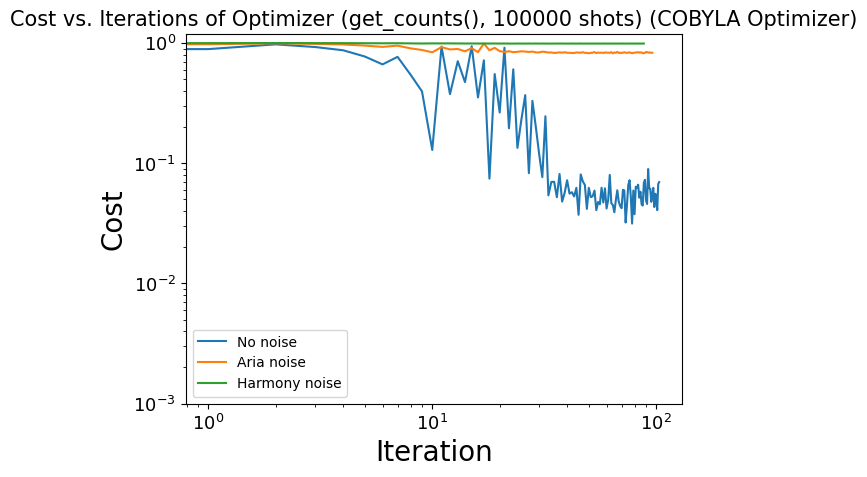

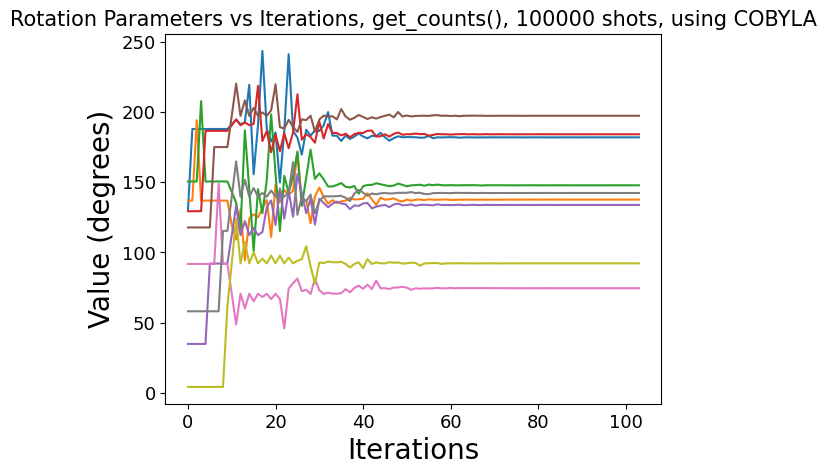

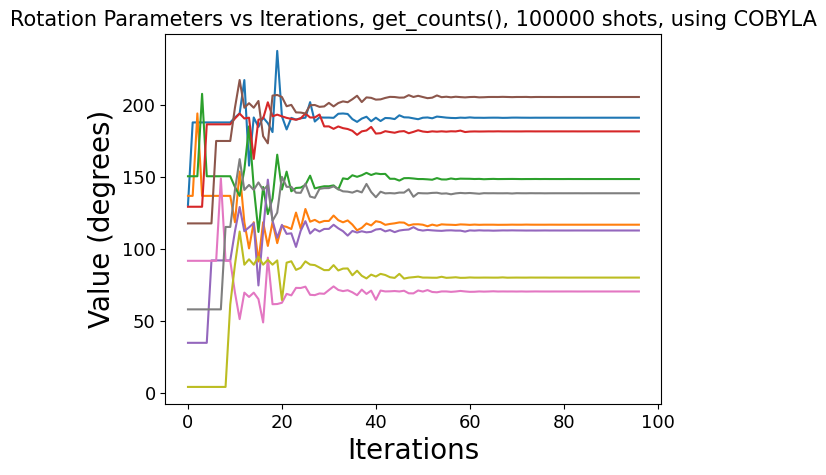

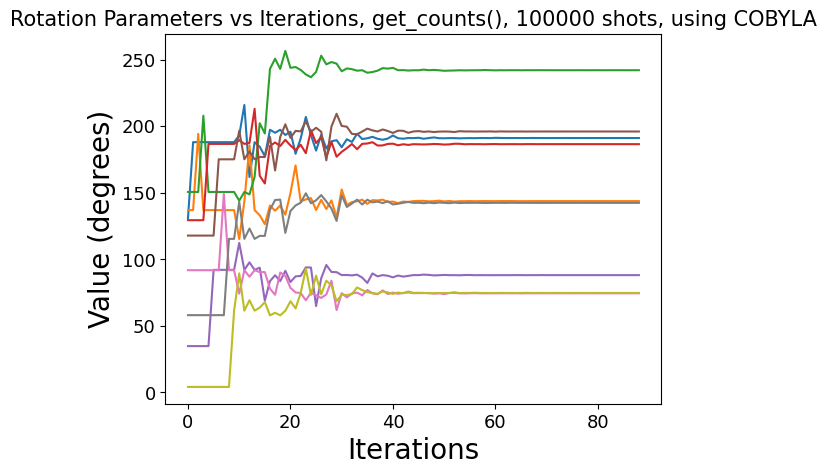

In [ ]:
import matplotlib.pyplot as plt
from math import pi
from functools import reduce


for i in range(len(models)):
    cost_plot = reduce(lambda a,h: a + [h] if not h == 0 else a, cost_sum[i], [])
    plt.loglog(cost_plot)


plt.xlabel('Iteration',fontsize=20)
plt.ylabel('Cost',fontsize=20)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(math.pow(10,-3))
plt.legend(models)

title = "Cost vs. Iterations of Optimizer (get_counts(), "  + str(SHOTS) +" shots) (COBYLA Optimizer)"
plt.title(title, fontsize=15)
plt.savefig(title +".pdf", bbox_inches='tight')
# Seed:
print("Starting  with k = " + str(k))
plt.show()

for j in range(len(models)):
    for i in range(len(all_params[0][0])):
        plt.plot(list(map(lambda h: (180/pi)*h[i], all_params[j])))

    plt.xlabel("Iterations", fontsize=20)
    plt.ylabel("Value (degrees)", fontsize=20)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    title = "Rotation Parameters vs Iterations, get_counts(), " + str(SHOTS) + " shots, using COBYLA" 
    plt.title(title, fontsize=15)
    plt.savefig(title + ".pdf", bbox_inches='tight')
    plt.show()


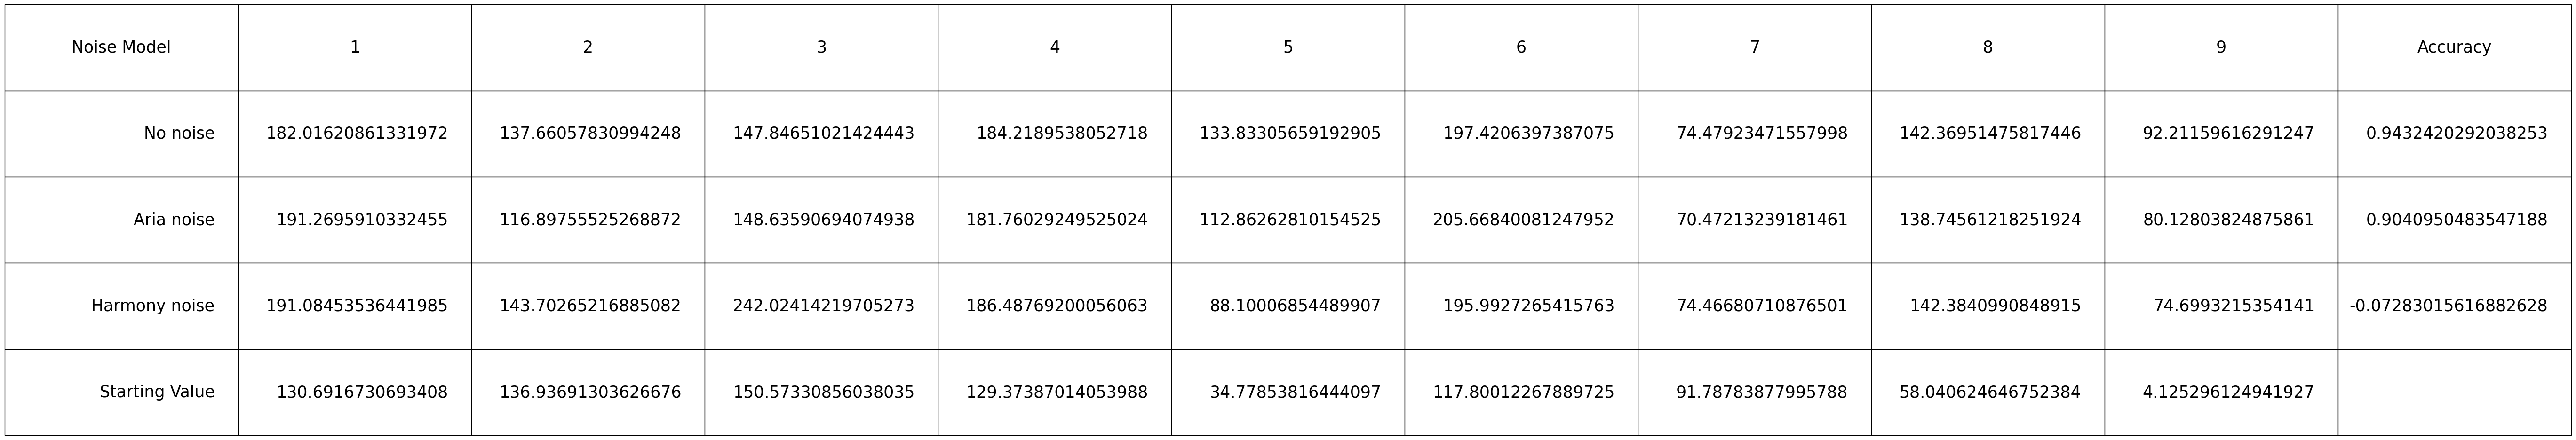

In [ ]:
import pandas as pd

all_params_table = []

cols = ["Noise Model"]
cols += [str(x+1) for x in range(9)]
cols += ["Accuracy"]

for j in range(len(models)):
    next_row = []
    next_row += [models[j]]
    for e in all_params[j][len(all_params[j])-1]:
        next_row += [e*(180/pi)]
    next_row += [(accuracy[j]).real]
    all_params_table += [next_row]

next_row = ["Starting Value"]
next_row += list(map(lambda h: h*(180/pi), k))
next_row += [""]
all_params_table += [next_row]

fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')

df = pd.DataFrame(all_params_table, columns=cols)

table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(25)
table.scale(11,11)
plt.savefig("Final Parameters and Accuracy, get_counts(), per noise model.pdf", bbox_inches='tight')
plt.show()

In [ ]:
print(list(map(lambda h: h.real, accuracy)))

[4.155865620405903e-06, 4.157013261362794e-06, 4.153725676103974e-06]
